# 导入数据

In [92]:
import numpy as np
import pandas as pd

import os
import random
from operator import itemgetter
import copy
import time
from sklearn.decomposition import PCA
import torch
import torchvision
import torchvision.transforms as transform
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torch.nn as nn
import torchvision.models as models
from torchvision.utils import make_grid
import torch.nn.functional as F

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 查看样本数据

In [96]:
example = './Covid19-dataset/train/Normal/01.jpeg'
path = './Covid19-dataset/train'

Shape: (1708, 1944, 3)


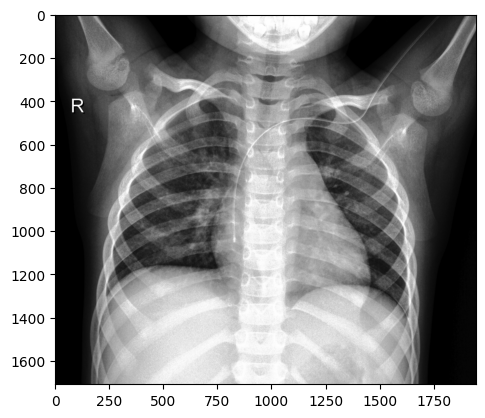

In [4]:
img = mpimg.imread(example)
print('Shape:', img.shape)
plt.imshow(img);

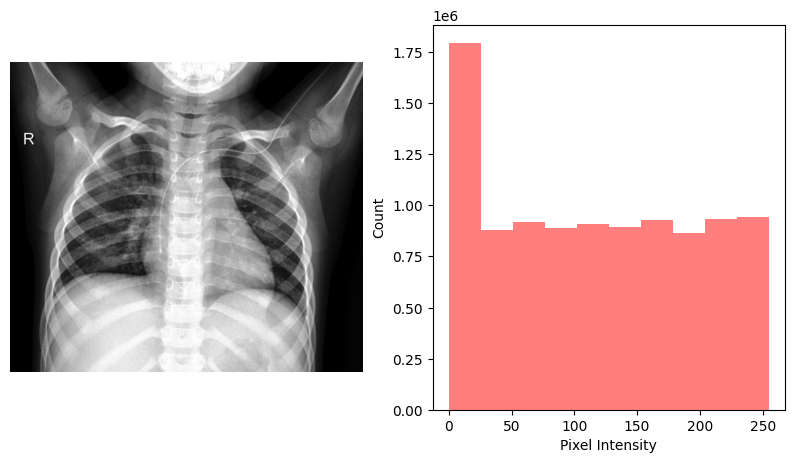

In [5]:
def plotHist(img):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.imshow(img)
  plt.axis('off')
  histo = plt.subplot(1,2,2)
  histo.set_ylabel('Count')
  histo.set_xlabel('Pixel Intensity')
  plt.hist(img.flatten(), bins=10, lw=0, alpha=0.5, color='r')

plotHist(img)

# 数据预处理与数据增强

In [94]:
transformer = {
    'original': transform.Compose([
        transform.Resize((224, 224)),
        transform.ToTensor(), 
        transform.Normalize((0.485, 0.456, 0.406),(0.229,0.224,0.225))
]), 
   'dataset1': transform.Compose([
       transform.Resize((224, 224)),
       #随机图像亮度、对比度、饱和度
       transform.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
       #随机翻转
       transform.RandomRotation(5),
       #随机放射变化
       transform.RandomAffine(degrees=11, translate=(0.1,0.1), scale=(0.8,0.8)),
       transform.ToTensor(),
       transform.Normalize((0.485, 0.456, 0.406),(0.229,0.224,0.225))
])
}

In [97]:
bs = 64

original = ImageFolder(path, transform=transformer['dataset1'])
train_val = original

train, val = train_test_split(train_val, test_size=0.2, shuffle=True, random_state=42)

loaders = {
    'train': DataLoader(train, batch_size=bs, num_workers=4, pin_memory=False),
    'val': DataLoader(val, batch_size=bs, num_workers=4, pin_memory=False),
}

dataset_sizes = {
    'train': len(train),
    'val': len(val), 
}

In [17]:
print('Classes:', original.classes)
print('Number of classes:', len(original.classes))

Classes: ['Covid', 'Normal', 'Viral Pneumonia']
Number of classes: 3


In [18]:
dic = {}

for classes in original.classes:
  dic[classes] = [len([os.path.join(path+'/'+classes, filename) for filename in os.listdir(path+'/'+classes)])]

samplesize = pd.DataFrame.from_dict(dic)

In [19]:
samplesize

Covid  Normal  Viral Pneumonia
0    111      70               70

# 数据标签统计

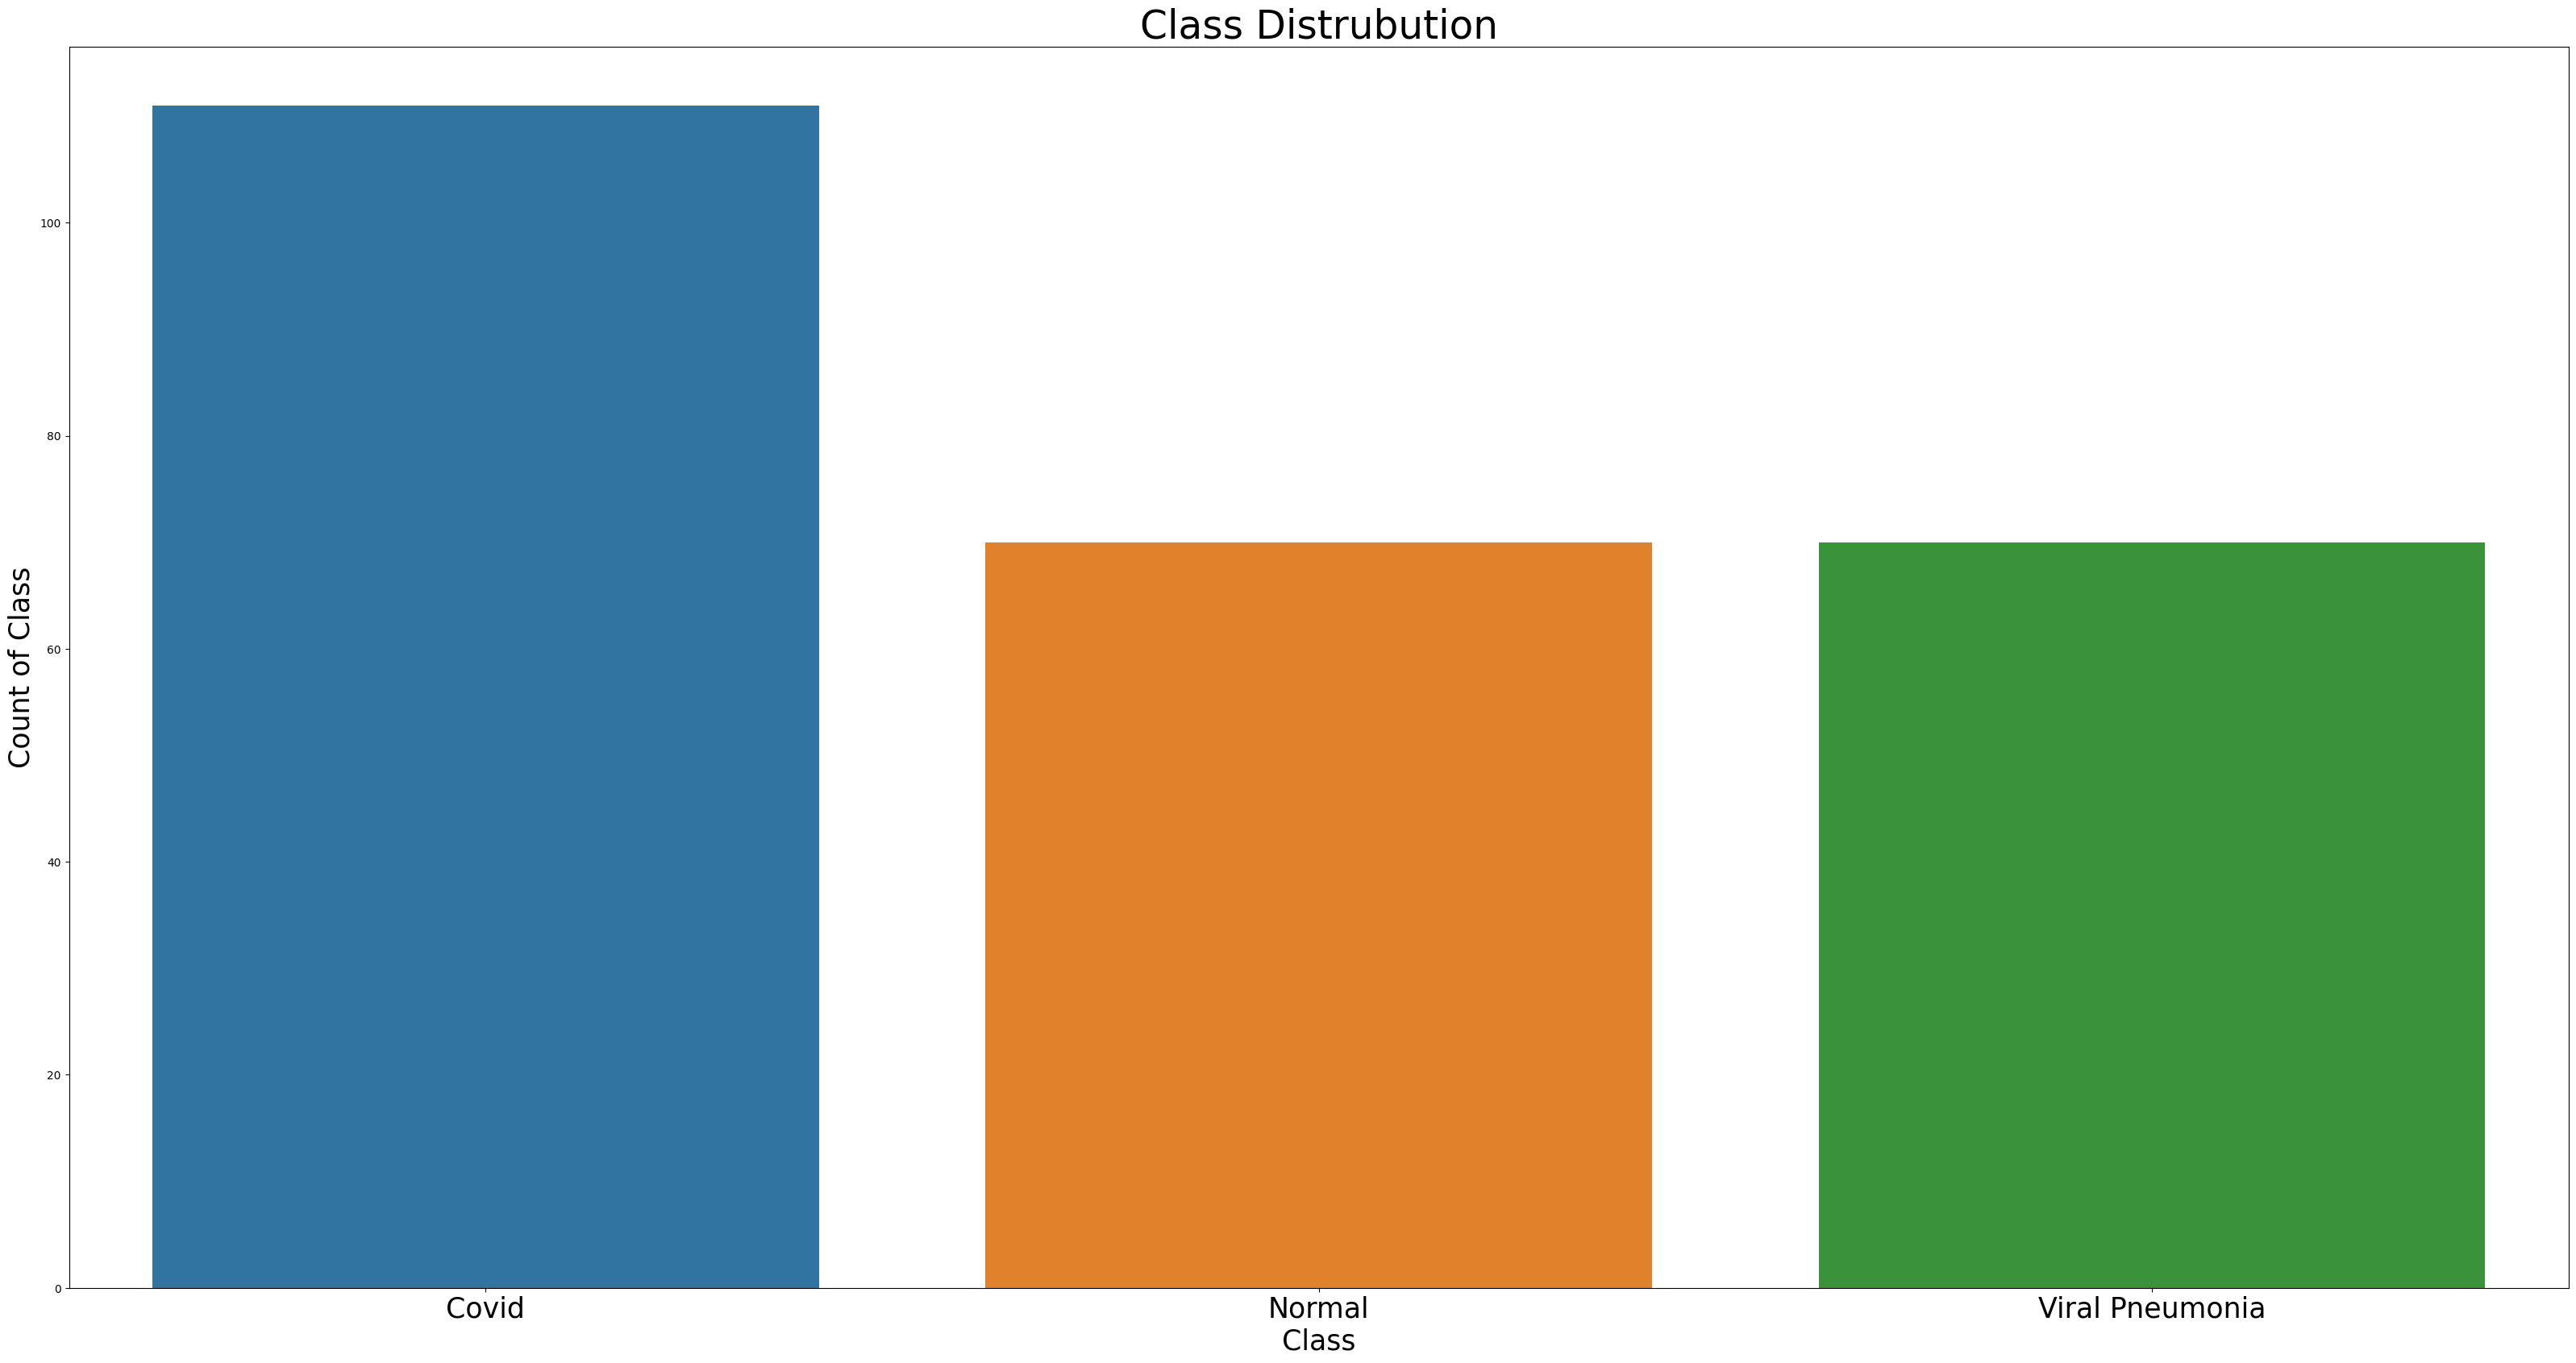

In [20]:
figure_size = plt.rcParams['figure.figsize']
figure_size[0] = 40
figure_size[1] = 20
plt.rcParams['figure.figsize'] = figure_size

sns.barplot(data=samplesize)

index = np.arange(len(original.classes))

plt.xlabel('Class', fontsize=25)
plt.ylabel('Count of Class', fontsize=25)
plt.xticks(index, original.classes, fontsize=25)
plt.title('Class Distrubution', fontsize=35)
plt.show()

# 数据探索性分析

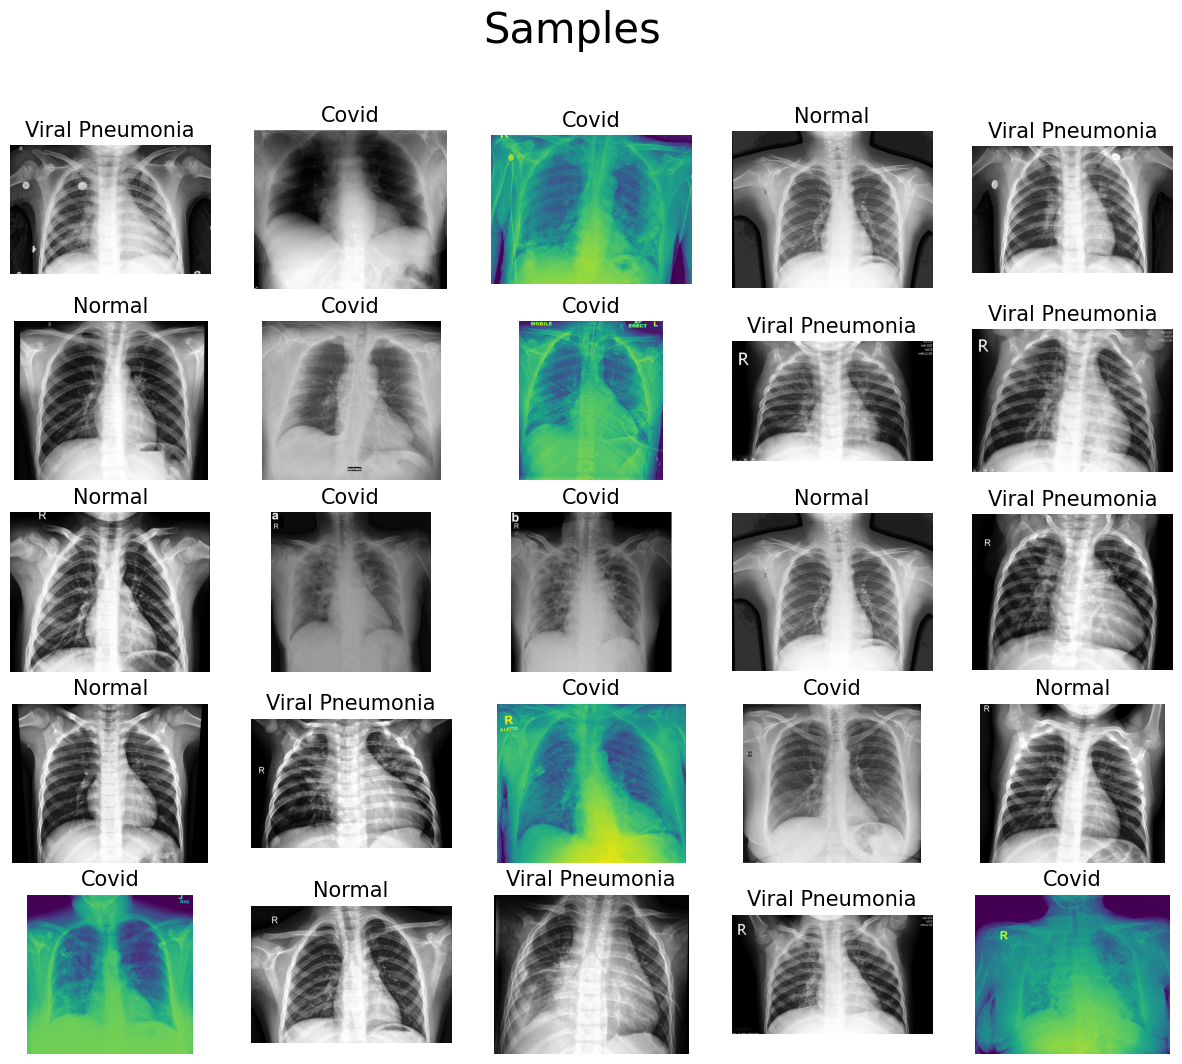

In [21]:
# Function for plotting samples
def plot_samples(samples):  
    fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(15,12))
    i = 0
    for row in range(5):
         for col in range(5):
                img = mpimg.imread(samples[i][0][0])
                ax[row][col].imshow(img)
                ax[row][col].axis('off')
                ax[row][col].set_title(samples[i][1], fontsize=15)
                i+=1
  

rand_samples = [] 
for _ in range(25): 
    classes = random.choice(original.classes)
    rand_samples.append([random.sample([os.path.join(path+'/'+classes, filename) for filename in os.listdir(path+'/'+classes)], 1), classes]) 
rand_samples[0]
plot_samples(rand_samples)
plt.suptitle('Samples', fontsize=30)
plt.show()

为了更深入地研究数据集的特征，我们进行了可视化分析，通过绘制每个类别的样本图像，我们可以更好地理解数据集的多样性和挑战性。这一步骤为我们提供了有关数据集内部结构的宝贵见解，为模型训练的优化提供了指导。
通过观察这些可视化图像，我们可以明显地看到每个类别的图像都展现出明显的差异性和多样性。这个多样性对于模型的建模是非常有益的，因为不同类别之间的显著差异性有助于模型更好地区分它们。举例来说，不同类型的水果和蔬菜可能在形状、大小、颜色和纹理等方面存在显著的差异。这种多样性为模型提供了足够的信息和特征，使其能够更准确地对各个类别进行分类。这些观察结果有助于我们了解数据集的挑战性，同时也提供了关于模型的训练和性能优化的有用指导。

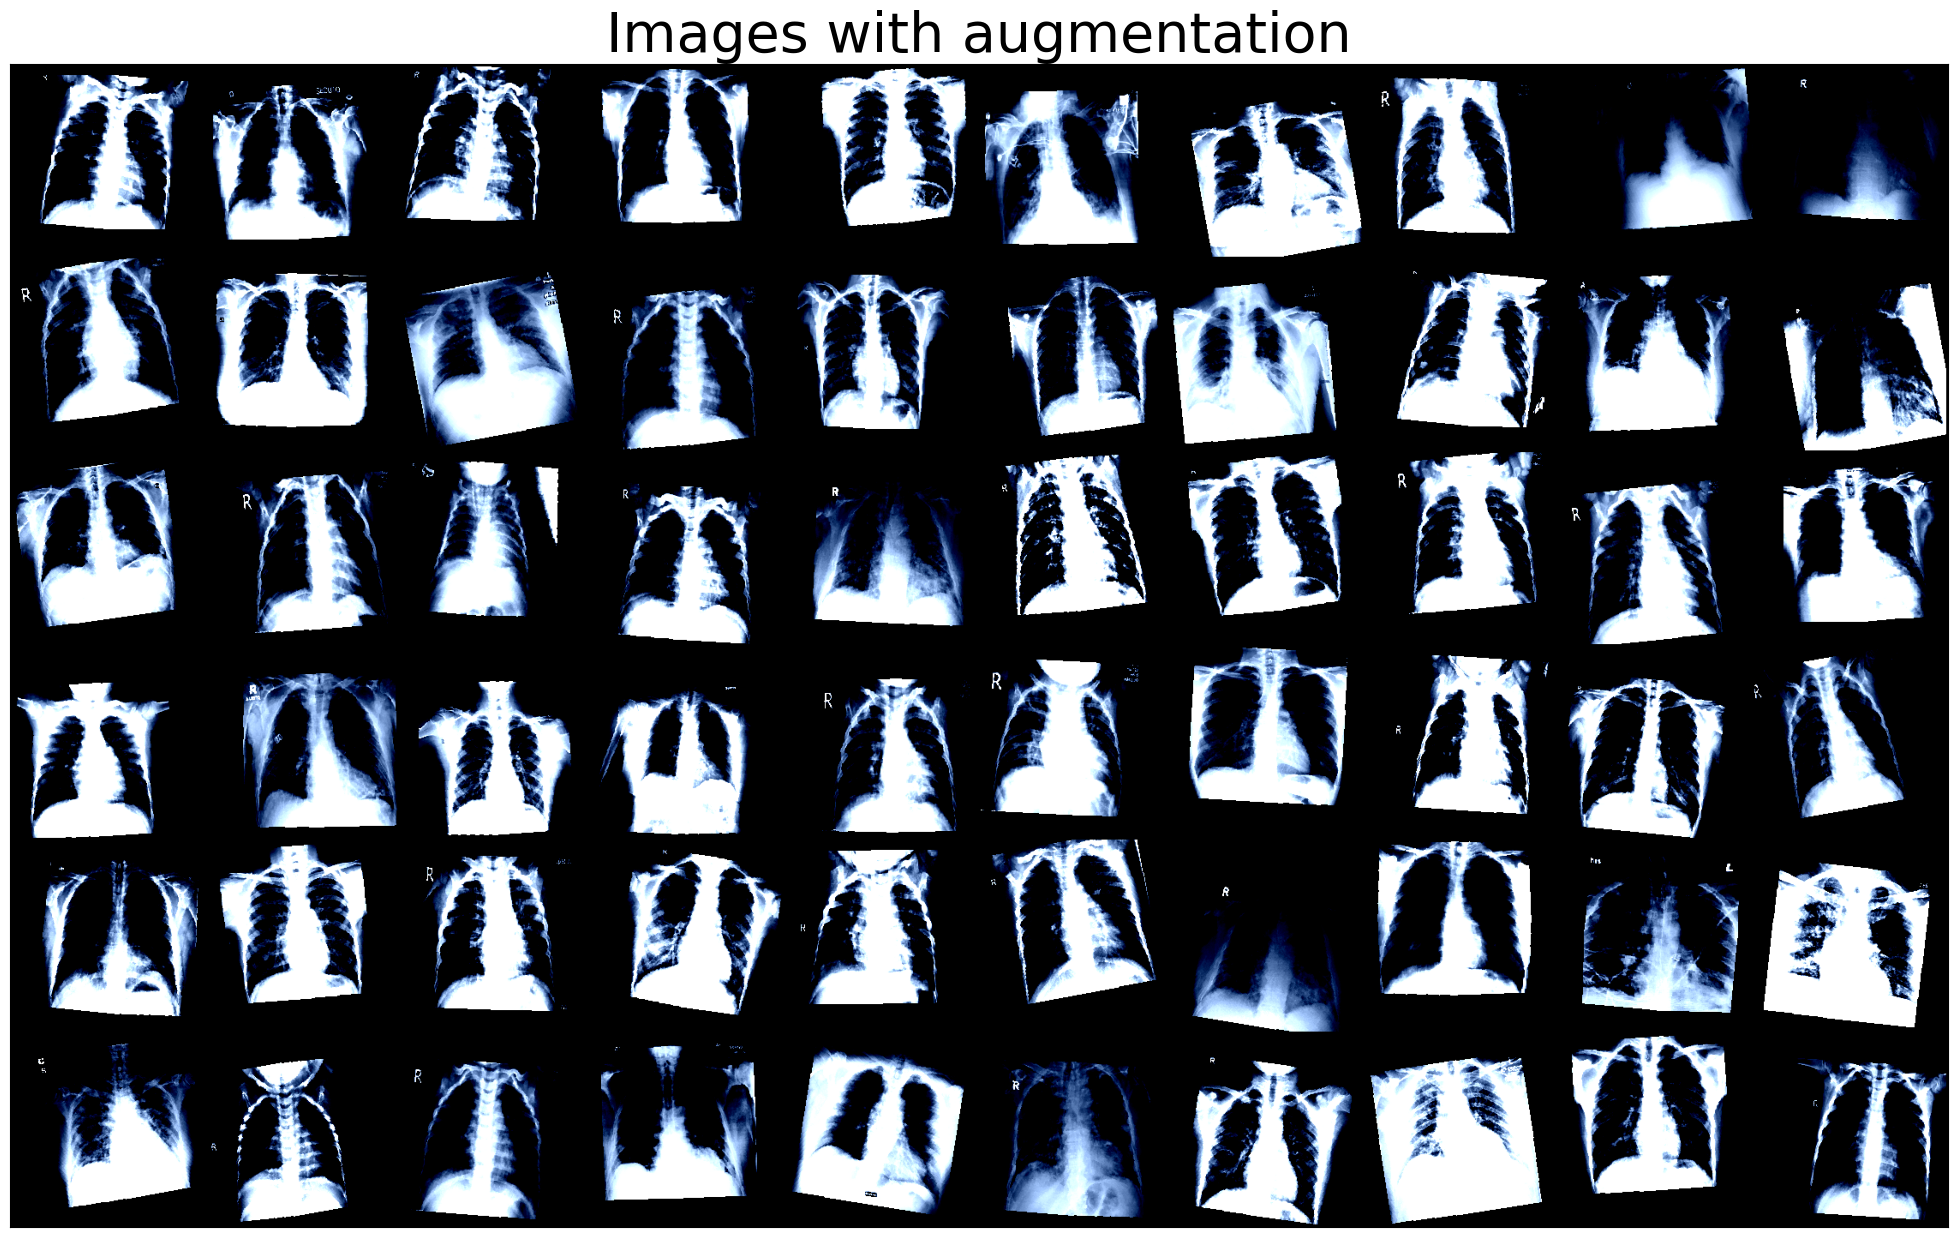

In [22]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(25, 25))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:60], nrow=10).permute(1, 2, 0))
        ax.set_title('Images with augmentation', fontsize=40)
        break
        
show_batch(loaders['train'])

在我们的研究中，我们关注的数据集原始数据具有丰富的特征和结构。每张图片作为一个数据点，其像素值构成了数据集的主要特征。
由于原始图像数据的特点，我们采取了特定的预处理方法来优化深度学习模型的训练效果。数据增强和归一化是两种关键的预处理技术，它们各自针对数据集的特定需求和特性来设计。
（1）数据增强：
原因： 图像数据可能存在方向、位置、尺寸等方面的差异，这可能导致模型对特定方向或位置的图像过于敏感。为了增加模型的泛化能力和稳健性，数据增强技术被用来模拟现实世界中的各种变化情况。
实施方法： 我们采用随机旋转和随机水平翻转。随机旋转通过对图像进行轻微旋转，增加了模型对不同角度的物体特征的学习能力。随机水平翻转则通过水平翻转图像来模拟不同的视角，从而提高了模型的鲁棒性。
（2）归一化：
原因： 图像数据的原始像素值范围可能非常宽广（通常是0-255），这样的尺度差异可能导致训练过程中的不稳定性，影响模型收敛的速度和效果。
实施方法： 通过减去预设的均值和除以标准差，我们将像素值归一化到一个较小的范围内。使用的均值[0.485, 0.456, 0.406]和标准差[0.229, 0.224, 0.225]是基于广泛的研究和验证，这有助于优化模型训练的稳定性和速度。归一化使数据更接近标准正态分布，减少了特征间的尺度差异，从而加快训练的收敛速度。
通过这些预处理技术，我们能够提升模型对原始数据集中存在的多样性和尺度差异的适应性，从而提高模型的泛化能力和训练效率。这些技术不仅有助于优化模型的性能，也使模型更能适应现实世界中各种复杂的输入情况。

# 定义相关函数

In [98]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

In [99]:
#save the losses for further visualization
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
lr = []

In [100]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_sizes, output_dim):
        super(FNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_sizes = hidden_sizes
        self.output_dim = output_dim

        # 构建输入层到第一个隐藏层的连接
        self.input_layer = nn.Linear(input_dim, hidden_sizes[0])
        
        # 构建隐藏层到隐藏层的连接
        self.hidden_layers = nn.ModuleList()
        for i in range(1, len(hidden_sizes)):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
        
        # 构建最后一个隐藏层到输出层的连接
        self.output_layer = nn.Linear(hidden_sizes[-1], output_dim)

    def forward(self, x):
        # 前向传播
        x = torch.flatten(x, 1)  # 将输入展平
        x = torch.relu(self.input_layer(x))
        
        for layer in self.hidden_layers:
            x = torch.relu(layer(x))
        
        x = self.output_layer(x)
        return x
    


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(module,train,val,epochs,model_name,device):
  torch.manual_seed(42)
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(module.parameters(), lr=0.00005) 
  accuracy_s=0
  accuracy1 = 0
  precision_list=[]
  recall_list=[]
  f1_list=[]
  precision_val = []
  recall_val = []
  f1_val = []
  loss_list=[]
  loss_list_val=[]
  accuracy_list=[]
  accuracy_val=[]
  #定义学习率调度器
  torch.manual_seed(42)
  for epoch in range(epochs):
      correct = 0
      total = 0
      ls_loss = []
      val_loss=[]
      for i, (images, labels) in enumerate(train):
#           if model_name in ['FNN']:
#                 images=images.reshape(-1,224*224*3)
          images = torch.Tensor(images).float().to(device)
          labels = torch.Tensor(labels).float().to(device)
          #torch.cuda.empty_cache()
          outputs = module(images)
          loss = criterion(outputs, labels.long())
          ls_loss.append(loss.item())
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()  # 更新参数

          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels.long()).sum().item()
          predicted = predicted.cpu().numpy()
          labels = labels.cpu().numpy()
      epoch_loss = sum(ls_loss) / len(ls_loss)
      loss_list.append(epoch_loss)
      accuracy = 100 * correct / total
      accuracy_list.append(accuracy)
      print('训练集: loss:{:.4f}, 准确率：{:.2f}%'.format(epoch_loss,accuracy))

      # 更新学习率
      module.eval()
      correct = 0
      total = 0
      with torch.no_grad():
          if accuracy_s < accuracy1:
              accuracy_s = accuracy1
              torch.save(module.state_dict(), 'model.pkl')
          for images, labels in val:
              images = torch.Tensor(images).float().to(device)
              labels = torch.Tensor(labels).float().to(device)
              outputs = module(images)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels.long()).sum().item()
              loss = criterion(outputs, labels.long())
              val_loss.append(loss.item())
          val_accuracy = 100 *correct/ total
          #scheduler.step(val_accuracy)
          epoch_loss = sum(val_loss) / len(val_loss)
          loss_list_val.append(epoch_loss)
          accuracy1 = val_accuracy

          accuracy_val.append(accuracy1)
          print('【{}/{}】验证集: loss:{:.4f}, 准确率：{:.2f}%'.format(epoch+1,epochs,epoch_loss, accuracy1))

  return module,loss_list,loss_list_val,accuracy_list,accuracy_val


def train_models(models_dict):
    # 模型训练和评估
    # 定义字典，保存模型和训练结果
    train_model_dict={}
    train_loss_dict={}
    train_acc_dict={}

    valid_loss_dict={}
    valid_acc_dict={}
    for model_name, model_func in models_dict.items():
        print("训练模型:", model_name)
        model = model_func
        model = model.to(device)


        #模型训练。返回最佳模型，训练结果
        model, train_loss, valid_loss, train_acc, valid_acc = train_model(model, train, val, epochs,model_name,device )
        train_model_dict[model_name]=model
        train_loss_dict[model_name]=train_loss
        train_acc_dict[model_name]=train_acc
        valid_loss_dict[model_name]=valid_loss
        valid_acc_dict[model_name]=valid_acc
        print('******************\n')
        
    return train_model_dict,train_loss_dict,train_acc_dict,valid_loss_dict,valid_acc_dict


def plot_metrics(train_model_dict,train_loss_dict,train_acc_dict,valid_loss_dict,valid_acc_dict):
    #绘制每个模型的训练损失
    plt.figure(figsize=(10, 8))
    for i,j in train_loss_dict.items():
        plt.plot(j, label='Train_'+i)

        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
    plt.show()
        
    #绘制每个模型的验证损失
    plt.figure(figsize=(10, 8))
    for i,j in valid_loss_dict.items():
        plt.plot(j, label='Valid_'+i)

        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
    plt.show()
        
    #绘制每个模型的训练准确率
    plt.figure(figsize=(10, 8))
    for i,j in train_acc_dict.items():

        train_acc=[]
        for i1 in j:
          train_acc.append(i1)
        plt.plot(train_acc, label='Train_'+i)

        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
    plt.show()
    #绘制每个模型的验证准确率
    plt.figure(figsize=(10, 8))
    for i,j in valid_acc_dict.items():

        valid_acc=[]
        for i1 in j:
          valid_acc.append(i1)
        plt.plot(valid_acc, label='Valid_'+i)

        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
    plt.show()
        
#定义函数绘制混淆矩阵
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',  #绘制混淆矩阵
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")  #加上标签数值

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')        
def plot_report_confusion(train_model_dict,val):
    metrics={}
    for i,model in train_model_dict.items():
        time1=time.time()
        model.eval() #模型预测模式
        y_true = []
        y_pred = []
        with torch.no_grad():
            for images, labels in val:
                  images = torch.Tensor(images).float().to(device)
                  labels = torch.Tensor(labels).float().to(device)
                  outputs = model(images)
                  _, predicted = torch.max(outputs.data, 1)
                  y_true.extend(labels.cpu().numpy())
                  y_pred.extend(predicted.cpu().numpy())
            time2=time.time()
            time_use=round((time2-time1)/len(y_true),4)
            # 计算准确率、召回率和F1值
            precision = precision_score(y_true, y_pred, average='macro')
            recall = recall_score(y_true, y_pred, average='macro')
            f1 = f1_score(y_true, y_pred, average='macro')
            acc=accuracy_score(y_true, y_pred)
            metrics[i]=[acc,precision,recall,f1,time_use]
        print("Classification Report for", i)
        print(classification_report(y_true, y_pred)) #打印分类报告
        print('\n')

        # 绘制混淆矩阵
        cnf_matrix = confusion_matrix(y_true, y_pred,normalize='true') #计算混淆矩阵
        plt.figure(figsize=(10, 8))
        np.set_printoptions(precision=2)

        class_names = original.classes
        #plt.figure(figsize=(5, 5))
        plot_confusion_matrix(cnf_matrix   #绘制混淆矩阵
                              , classes=class_names
                              , title='Confusion matrix')
        plt.show()
        
    d=pd.DataFrame(metrics,columns=metrics.keys()).T
    d.columns=['Accuracy','Precision','Recall','F1 score','Average cls Time']

    return d

In [101]:
# 初始化空的字典来存储数据
data = {}

# 提取数据
for split, dataloader in loaders.items():
    x, y = [], []
    for batch in dataloader:
        x_batch, y_batch = batch
        x.append(x_batch.numpy())  # 将张量转换为NumPy数组
        y.append(y_batch.numpy())
    data[f'x_{split}'] = np.concatenate(x, axis=0)  # 拼接所有批次的数据
    data[f'y_{split}'] = np.concatenate(y, axis=0)

# PCA分析

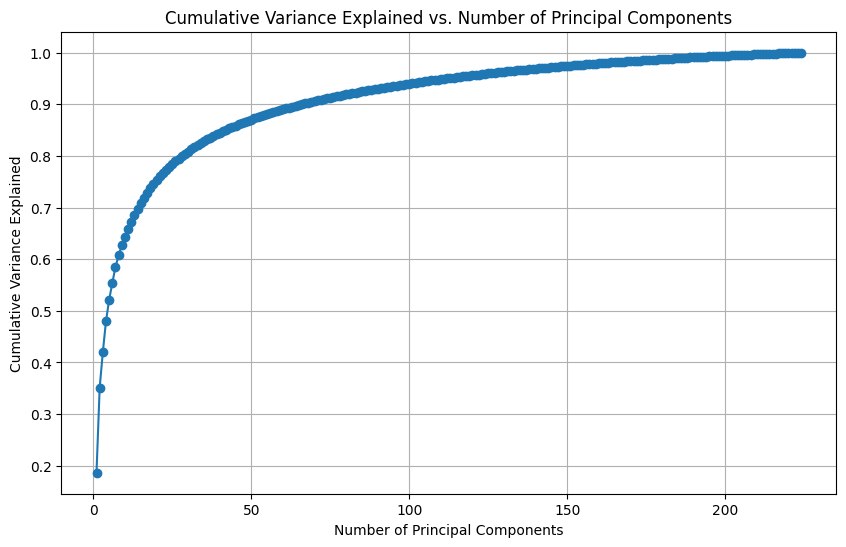

In [29]:
# 获取x_train数据
x_train = data['x_train']

# 将三通道图片展平为一维向量
x_train_flattened = x_train.reshape(x_train.shape[0], -1)

# 初始化PCA模型并设置目标维度为224
n_components = 224
pca = PCA(n_components=n_components)

# 拟合PCA模型
pca.fit(x_train_flattened)

# 计算方差解释的累积和
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# 绘制方差解释的累积和图表
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, n_components + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained vs. Number of Principal Components')
plt.grid(True)
plt.show()

在本研究中，我们通过主成分分析（PCA）降维技术对图像特征进行了处理，以探索数据集中的特征冗余性和优化特征维度。通过分析方差解释性曲线图，我们发现在大约100个主成分（特征）时，方差解释性接近100%。这一结果表明，图像数据中存在明显的特征冗余性，其中许多特征对数据的解释性能力有限。
方差解释性曲线图是一种有效的工具，用于评估数据中特征的重要性以及确定降维的适当维度。在我们的情况下，这个曲线揭示了数据集中的特征不仅具有冗余性，而且维度迅速降低后，方差解释性仍能够保持在较高水平，这表明存在一些主要的特征可以捕捉数据中的大部分信息。
这个发现对于深度学习模型的训练非常重要。高维度特征可能导致模型的过拟合，增加计算复杂性，降低训练效率，并可能导致性能下降。因此，通过PCA降维，我们可以选择保留相对较少的特征，仍然能够保留大部分信息，从而减轻了模型的负担。

In [103]:
# 定义一个函数来执行模型训练和超参数调优
def train_evaluate_model(model, param_grid, name):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # 获取最佳模型
    best_model = grid_search.best_estimator_
    
    # 在验证集上评估性能
    y_pred = best_model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='macro')
    recall = recall_score(y_val, y_pred, average='macro')
    precision = precision_score(y_val, y_pred, average='macro')
    
    # 绘制准确率随超参数变化的曲线
    plt.figure(figsize=(5, 5))
    plt.scatter(param_grid[name], grid_search.cv_results_['mean_test_score'], marker='o', linestyle='--')
    plt.title(f"{name} vs. Accuracy")
    plt.xlabel(name)
    plt.ylabel("Accuracy")
    plt.show()
    print(param_grid[name], grid_search.cv_results_['mean_test_score'])
    
    # 计算混淆矩阵
    cm = confusion_matrix(y_val, y_pred)
    return best_model, accuracy, f1, recall, precision,cm


# 绘制混淆矩阵
def plot_confusion_matrixR2(cm, classes, model_name):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    #plt.show()

import itertools


class LeNet(nn.Module):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(44944, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    
class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
class BasicCNN(nn.Module):
    def __init__(self, num_classes):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.fc = nn.Linear(32 * 224 * 224, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = x.view(x.size(0), -1)  # 展平特征
        x = self.fc(x)
        return x

# 机器学习建模

In [104]:
# 获取特征和标签
X_train = data['x_train']  # 特征
y_train = data['y_train']  # 标签
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = data['x_val']  # 特征
y_val = data['y_val']  # 标签
X_val = X_val.reshape(X_val.shape[0], -1)
# 降维到100维
n_components = 100
pca = PCA(n_components=n_components)
X_train = pca.fit_transform(X_train)
X_val = pca.transform(X_val)

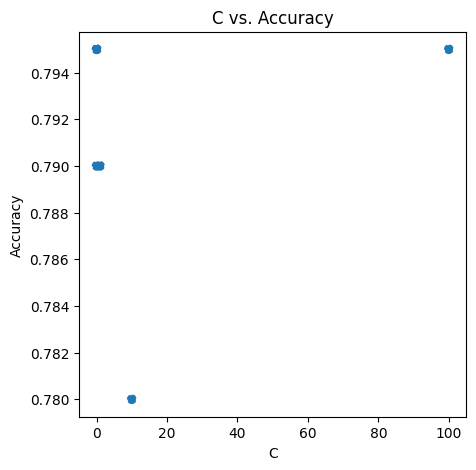

[0.001, 0.01, 0.1, 1, 10, 100] [0.79 0.79 0.79 0.79 0.78 0.79]


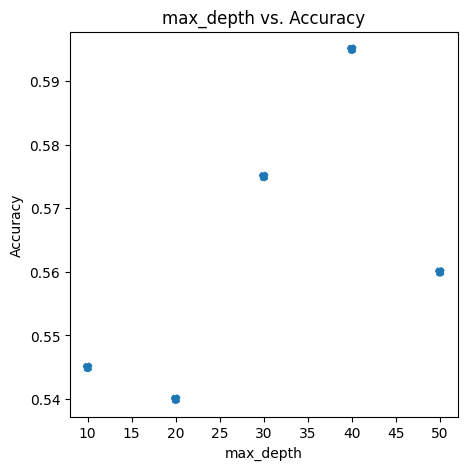

[None, 10, 20, 30, 40, 50] [0.58 0.54 0.54 0.57 0.59 0.56]


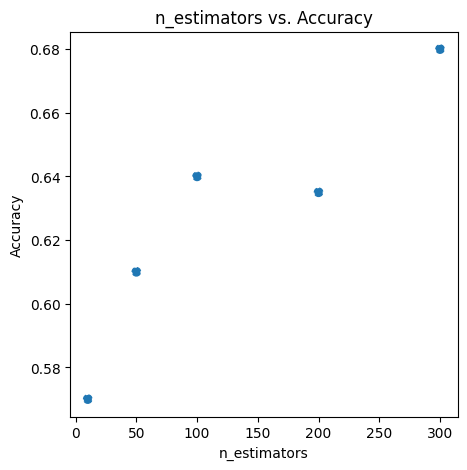

[10, 50, 100, 200, 300] [0.57 0.61 0.64 0.64 0.68]


Model  Accuracy  F1 Score    Recall  Precision
0  Logistic Regression  0.823529  0.810232  0.795031   0.856862
1        Decision Tree  0.568627  0.534359  0.532091   0.543210
2        Random Forest  0.588235  0.459770  0.527950   0.412698

In [105]:

# 超参数网格
param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}  # 逻辑回归超参数
param_grid_dt = {'max_depth': [None, 10, 20, 30, 40, 50]}  # 决策树超参数
param_grid_rf = {'n_estimators': [10, 50, 100, 200, 300]}  # 随机森林超参数

# 训练和评估逻辑回归模型
logistic_regression = LogisticRegression(max_iter=1000)
best_logistic_regression, acc_lr, f1_lr, recall_lr, precision_lr, cm_lr = train_evaluate_model(logistic_regression, param_grid_lr, 'C')

# 训练和评估决策树模型
decision_tree = DecisionTreeClassifier()
best_decision_tree, acc_dt, f1_dt, recall_dt, precision_dt, cm_dt = train_evaluate_model(decision_tree, param_grid_dt, 'max_depth')

# 训练和评估随机森林模型
random_forest = RandomForestClassifier()
best_random_forest, acc_rf, f1_rf, recall_rf, precision_rf, cm_rf = train_evaluate_model(random_forest, param_grid_rf, 'n_estimators')

# 整理结果成DataFrame
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Accuracy': [acc_lr, acc_dt, acc_rf],
    'F1 Score': [f1_lr, f1_dt, f1_rf],
    'Recall': [recall_lr, recall_dt, recall_rf],
    'Precision': [precision_lr, precision_dt, precision_rf]
})

# 输出结果
results

在比较逻辑回归、决策树和随机森林这三种模型的性能时，我们主要依据的评估指标包括准确率（Accuracy）、F1分数（F1 Score）、召回率（Recall）和精确度（Precision）。逻辑回归模型在这些评估指标上的表现最为优异，其准确率达到了82.35%，F1分数为81.02%，召回率为79.50%，精确度为85.69%。这表明逻辑回归模型在平衡正负样本分类时表现出较高的准确性和稳定性。

相比之下，决策树模型的准确率仅为56.86%，F1分数为53.44%，召回率为53.21%，精确度为54.32%。这一结果指出决策树模型在处理该数据集时的性能较差，可能是因为决策树易于过拟合，对于训练数据的小波动较为敏感，导致在未知数据上的泛化能力不足。

随机森林模型的准确率为58.82%，F1分数为45.98%，召回率为52.80%，精确度为41.27%。虽然随机森林在准确率上略高于决策树模型，但其F1分数和精确度较低，这可能是因为随机森林在合并多个决策树的预测结果时，如果存在大量的噪声，其性能会受到影响。

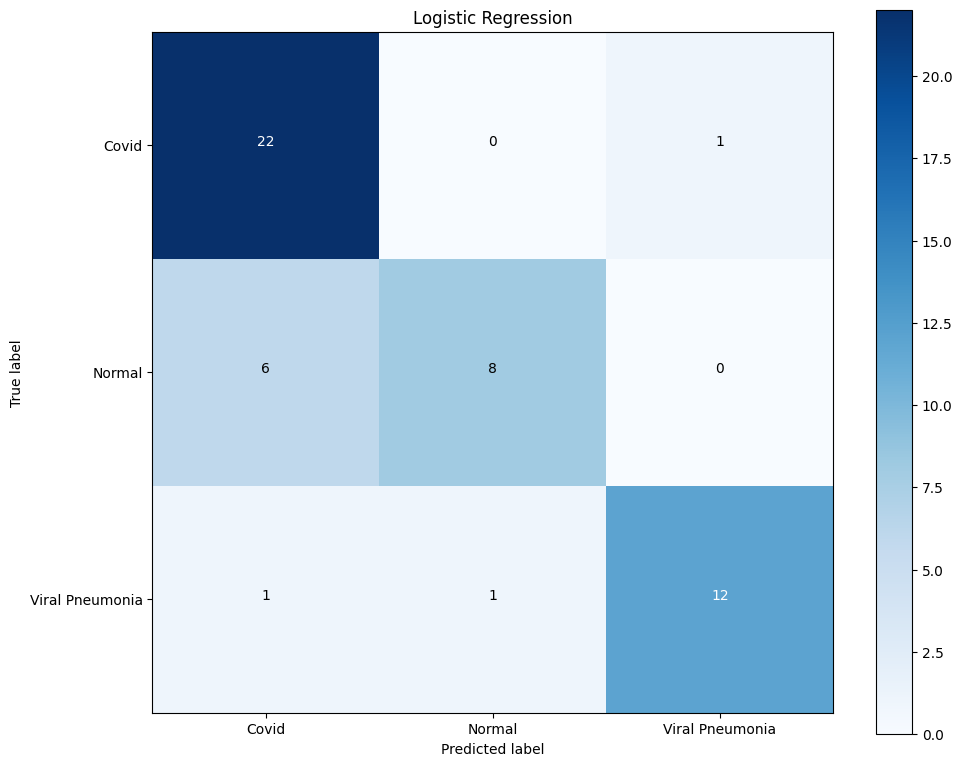

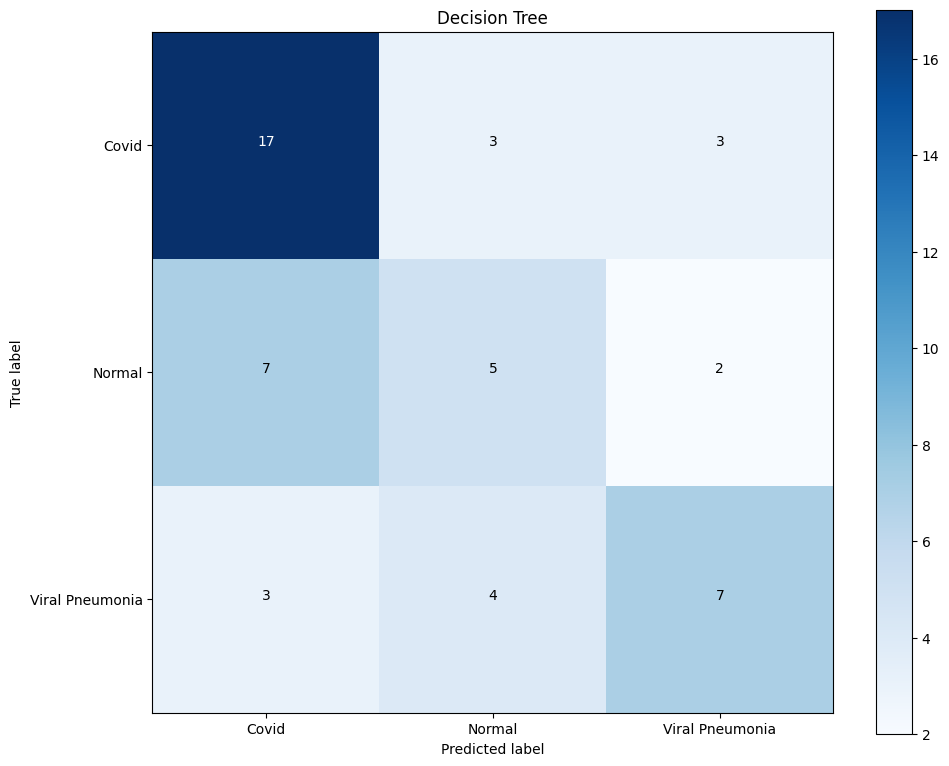

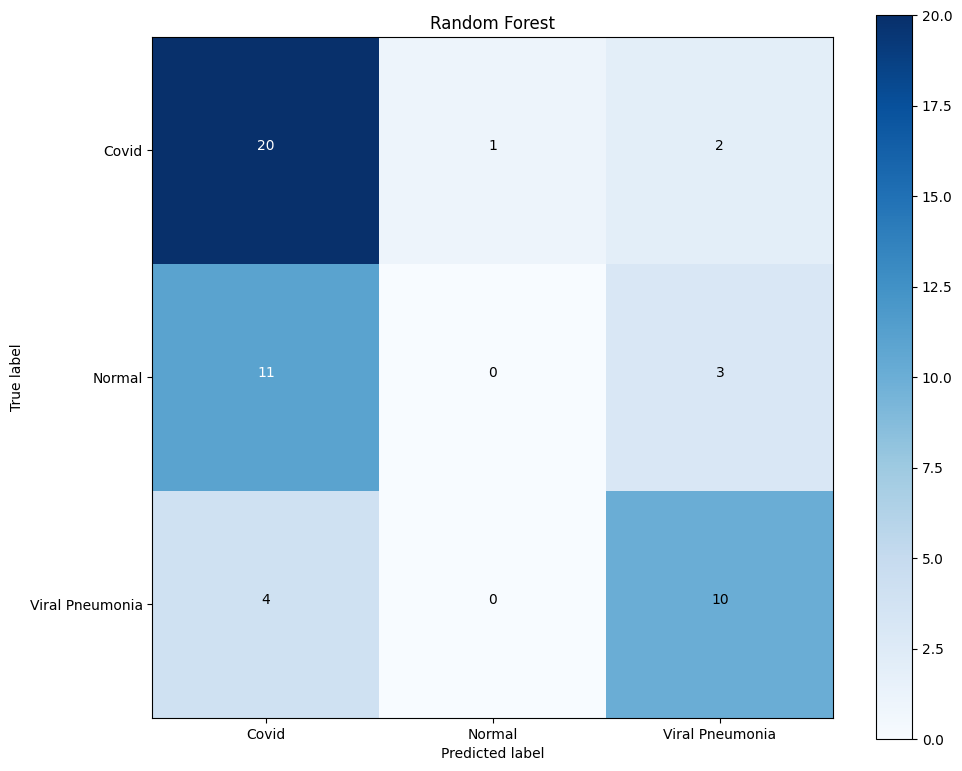

In [106]:
class_names=original.classes
# 显示逻辑回归混淆矩阵
plot_confusion_matrix(cm_lr, class_names, 'Logistic Regression')
plt.show()
# 显示决策树混淆矩阵
plot_confusion_matrix(cm_dt, class_names, 'Decision Tree')
plt.show()
# 显示随机森林混淆矩阵
plot_confusion_matrix(cm_rf, class_names, 'Random Forest')

plt.show()

In [107]:
cm_lr

array([[22,  0,  1],
       [ 6,  8,  0],
       [ 1,  1, 12]], dtype=int64)

In [108]:
cm_dt

array([[17,  3,  3],
       [ 7,  5,  2],
       [ 3,  4,  7]], dtype=int64)

In [109]:
cm_rf

array([[20,  1,  2],
       [11,  0,  3],
       [ 4,  0, 10]], dtype=int64)

# 全连接神经网络建模

In [17]:
epochs=20
train, val=loaders['train'],loaders['val']
input_dim=224*224*3
output_dim=3
models_dict = {
        
"FNN1": FNN(input_dim, [128,128,128], output_dim),
"FNN2": FNN(input_dim, [256,256,256], output_dim),
   "FNN3": FNN(input_dim, [512,512,512], output_dim),
}
train_model_dict,train_loss_dict,train_acc_dict,valid_loss_dict,valid_acc_dict=train_models(models_dict)

训练模型: FNN1
训练集: loss:4.8725, 准确率：47.50%
【1/20】验证集: loss:4.4693, 准确率：45.10%
训练集: loss:4.6883, 准确率：39.50%
【2/20】验证集: loss:2.3258, 准确率：66.67%
训练集: loss:2.5481, 准确率：53.50%
【3/20】验证集: loss:0.8834, 准确率：72.55%
训练集: loss:0.8335, 准确率：73.50%
【4/20】验证集: loss:1.0539, 准确率：76.47%
训练集: loss:0.9516, 准确率：75.00%
【5/20】验证集: loss:0.8658, 准确率：80.39%
训练集: loss:0.5701, 准确率：83.00%
【6/20】验证集: loss:1.1537, 准确率：76.47%
训练集: loss:0.7002, 准确率：80.50%
【7/20】验证集: loss:0.8684, 准确率：78.43%
训练集: loss:0.5030, 准确率：81.50%
【8/20】验证集: loss:0.7101, 准确率：82.35%
训练集: loss:0.2162, 准确率：93.00%
【9/20】验证集: loss:0.7265, 准确率：84.31%
训练集: loss:0.2307, 准确率：91.00%
【10/20】验证集: loss:0.3633, 准确率：88.24%
训练集: loss:0.1403, 准确率：91.50%
【11/20】验证集: loss:0.4293, 准确率：86.27%
训练集: loss:0.0417, 准确率：99.00%
【12/20】验证集: loss:0.6988, 准确率：82.35%
训练集: loss:0.0639, 准确率：96.50%
【13/20】验证集: loss:0.5747, 准确率：82.35%
训练集: loss:0.0269, 准确率：99.00%
【14/20】验证集: loss:0.5510, 准确率：84.31%
训练集: loss:0.0171, 准确率：100.00%
【15/20】验证集: loss:0.6005, 准确率：82.35%
训练集: loss:0.0105, 准确率：

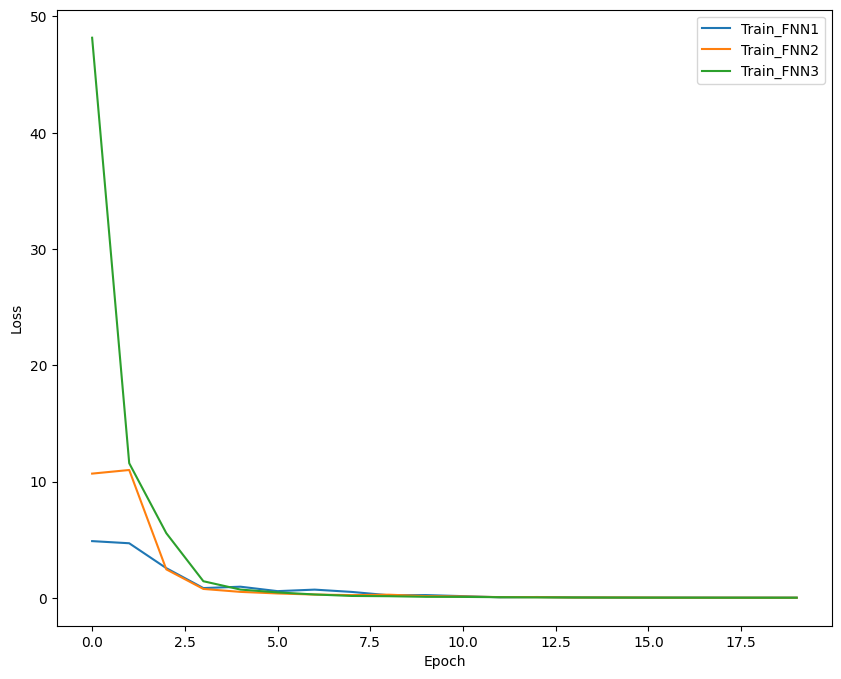

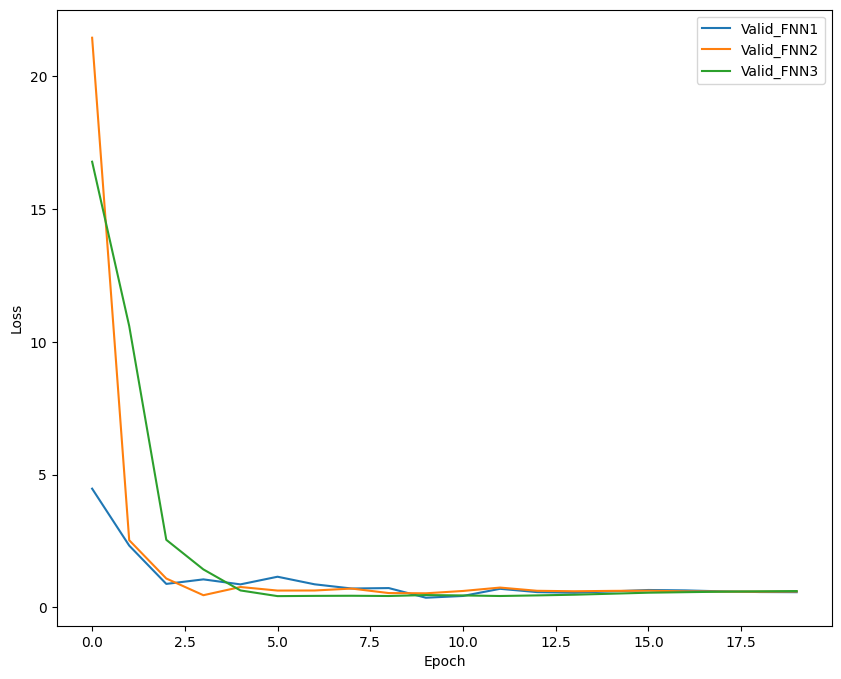

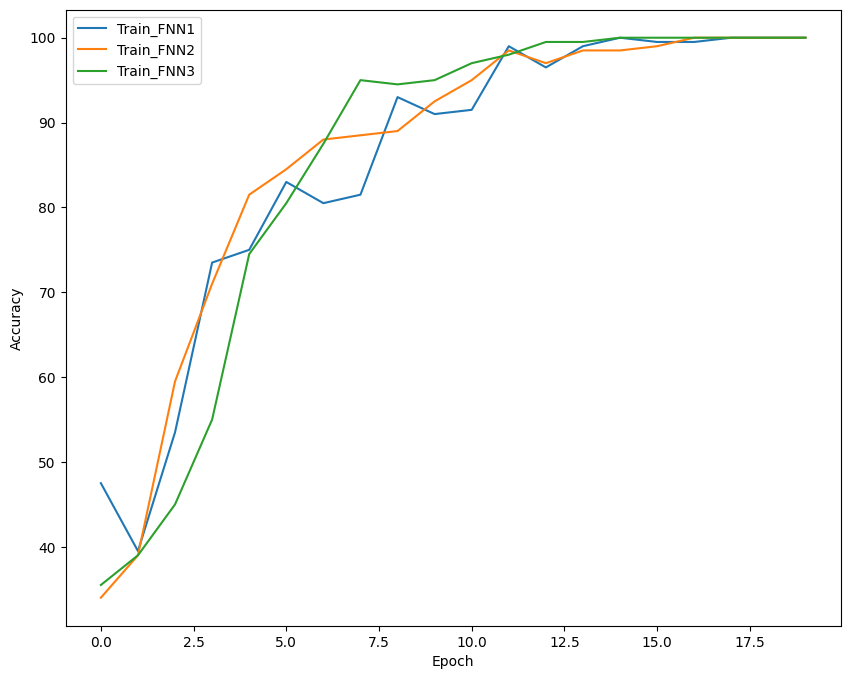

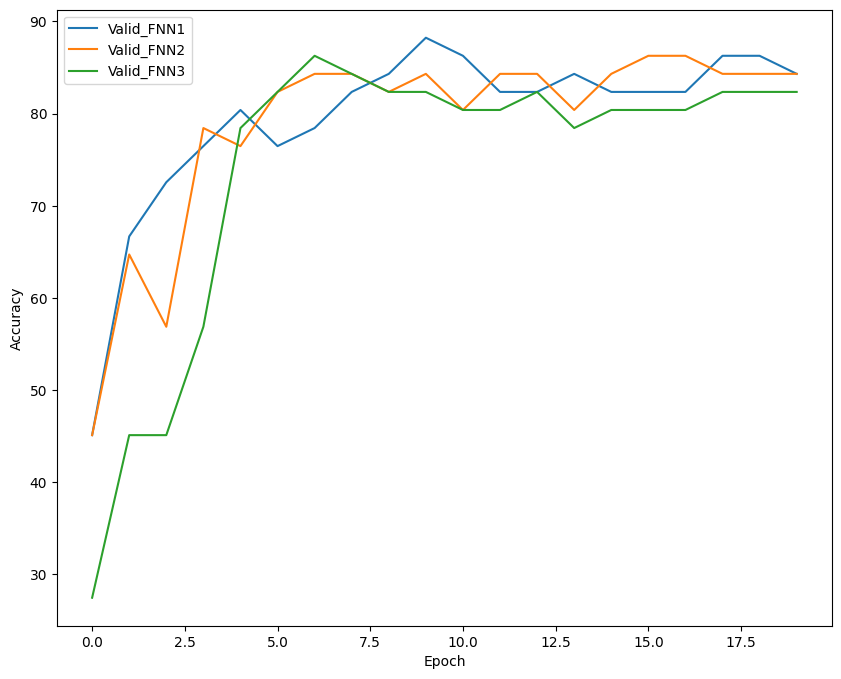

In [19]:
plot_metrics(train_model_dict,train_loss_dict,train_acc_dict,valid_loss_dict,valid_acc_dict)

Classification Report for FNN1
              precision    recall  f1-score   support

         0.0       0.88      0.91      0.89        23
         1.0       0.82      0.64      0.72        14
         2.0       0.81      0.93      0.87        14

    accuracy                           0.84        51
   macro avg       0.84      0.83      0.83        51
weighted avg       0.84      0.84      0.84        51





<Figure size 1000x800 with 0 Axes>

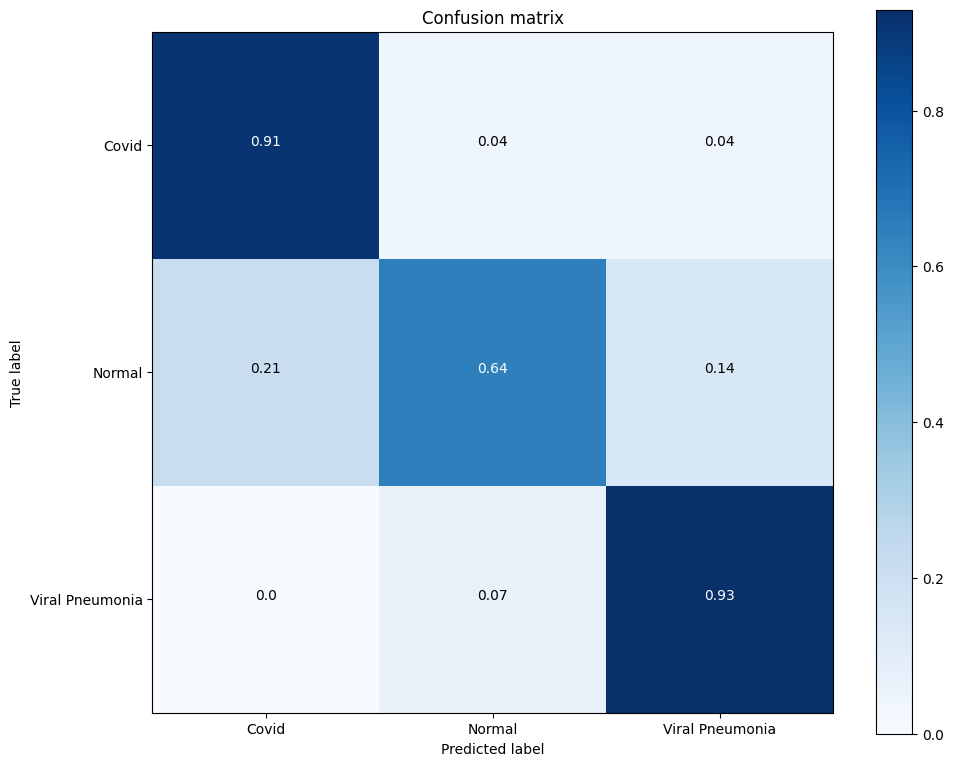

Classification Report for FNN2
              precision    recall  f1-score   support

         0.0       0.84      0.91      0.87        23
         1.0       0.77      0.71      0.74        14
         2.0       0.92      0.86      0.89        14

    accuracy                           0.84        51
   macro avg       0.84      0.83      0.83        51
weighted avg       0.84      0.84      0.84        51





<Figure size 1000x800 with 0 Axes>

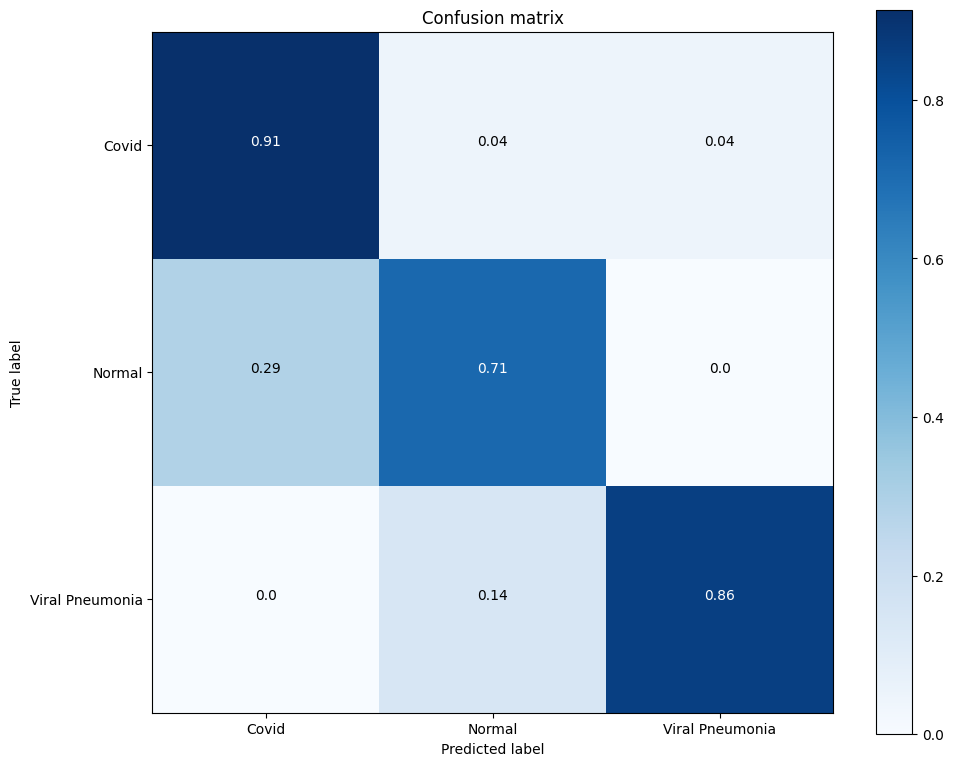

Classification Report for FNN3
              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83        23
         1.0       0.83      0.71      0.77        14
         2.0       0.81      0.93      0.87        14

    accuracy                           0.82        51
   macro avg       0.82      0.82      0.82        51
weighted avg       0.82      0.82      0.82        51





<Figure size 1000x800 with 0 Axes>

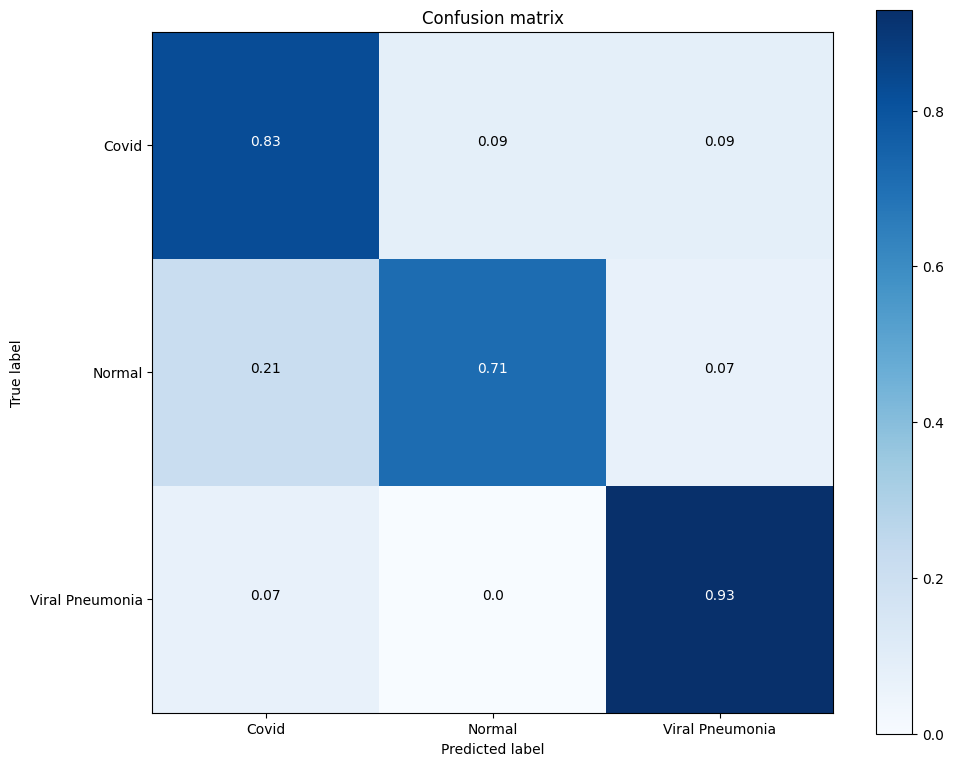

Accuracy  Precision    Recall  F1 score  Average cls Time
FNN1  0.843137   0.835227  0.828157  0.826761            0.0037
FNN2  0.843137   0.844103  0.828157  0.834877            0.0037
FNN3  0.823529   0.823973  0.822981  0.820661            0.0036

In [20]:
d=plot_report_confusion(train_model_dict,val)
d


在对全连接神经网络（FNN）的三种不同配置进行性能评估时，我们比较了它们的准确率、精确度、召回率、F1分数以及平均分类时间。这三种配置分别是FNN1（具有三层，每层128个神经元），FNN2（具有三层，每层256个神经元），以及FNN3（具有三层，每层512个神经元）。通过比较，我们发现FNN1和FNN2在准确率上均达到了84.31%，而FNN3的准确率略低，为82.35%。在精确度、召回率和F1分数方面，FNN2显示出略微优于FNN1和FNN3的性能，其精确度为84.41%，召回率为82.82%，F1分数为83.49%。值得注意的是，尽管FNN3拥有更多的神经元，但其性能并未显著超越FNN1和FNN2，这可能说明在一定程度上增加网络的复杂度并不总是能带来性能的提升。

在与之前性能最佳的机器学习模型——逻辑回归相比较时，全连接神经网络FNN2在所有主要评估指标上均表现出轻微的优势。逻辑回归模型的准确率为82.35%，而FNN2的准确率为84.31%；逻辑回归的精确度为85.69%，而FNN2为84.41%；在F1分数上，逻辑回归为81.02%，FNN2为83.49%。这一对比表明，尽管逻辑回归模型在某些情况下提供了非常竞争性的性能，但全连接神经网络特别是较为复杂的配置能够提供更好的准确率和整体性能。

# 卷积神经网络建模

In [31]:
epochs=20
train, val=loaders['train'],loaders['val']
output_dim=3
models_dict = {
        
"CNN1":  BasicCNN(output_dim),
"CNN2":  LeNet(output_dim),
   "CNN3":  AlexNet(output_dim),
}
train_model_dict,train_loss_dict,train_acc_dict,valid_loss_dict,valid_acc_dict=train_models(models_dict)

训练模型: CNN1
训练集: loss:9.5774, 准确率：33.00%
【1/20】验证集: loss:11.5985, 准确率：52.94%
训练集: loss:7.2725, 准确率：56.50%
【2/20】验证集: loss:1.9046, 准确率：72.55%
训练集: loss:2.4695, 准确率：62.50%
【3/20】验证集: loss:1.0100, 准确率：82.35%
训练集: loss:1.6632, 准确率：72.00%
【4/20】验证集: loss:1.5618, 准确率：76.47%
训练集: loss:0.8564, 准确率：90.50%
【5/20】验证集: loss:1.5126, 准确率：80.39%
训练集: loss:0.6869, 准确率：84.50%
【6/20】验证集: loss:0.9855, 准确率：82.35%
训练集: loss:0.3584, 准确率：90.50%
【7/20】验证集: loss:1.9638, 准确率：66.67%
训练集: loss:0.4536, 准确率：87.50%
【8/20】验证集: loss:0.9042, 准确率：82.35%
训练集: loss:0.1506, 准确率：93.50%
【9/20】验证集: loss:1.0421, 准确率：86.27%
训练集: loss:0.2187, 准确率：92.50%
【10/20】验证集: loss:0.8696, 准确率：88.24%
训练集: loss:0.0389, 准确率：98.00%
【11/20】验证集: loss:1.2005, 准确率：78.43%
训练集: loss:0.0703, 准确率：97.50%
【12/20】验证集: loss:1.3665, 准确率：78.43%
训练集: loss:0.0632, 准确率：97.50%
【13/20】验证集: loss:1.1834, 准确率：80.39%
训练集: loss:0.0154, 准确率：99.50%
【14/20】验证集: loss:0.9467, 准确率：86.27%
训练集: loss:0.0082, 准确率：99.50%
【15/20】验证集: loss:0.7969, 准确率：88.24%
训练集: loss:0.0075, 准确率：

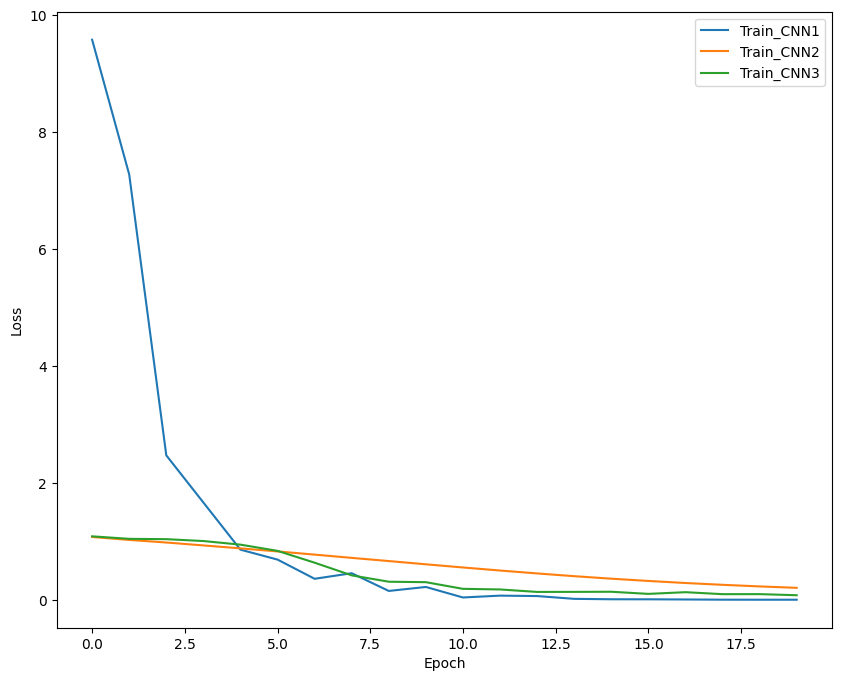

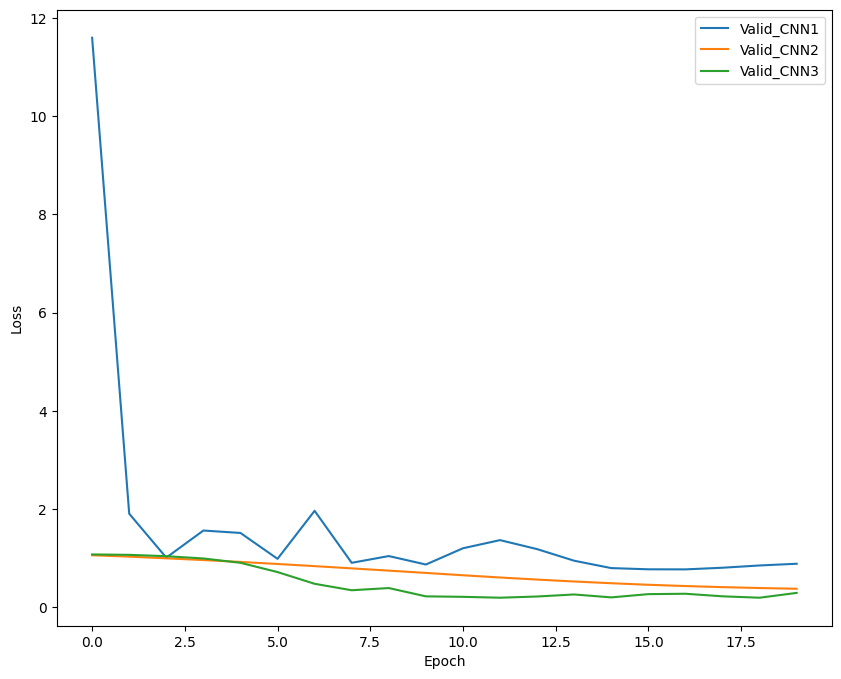

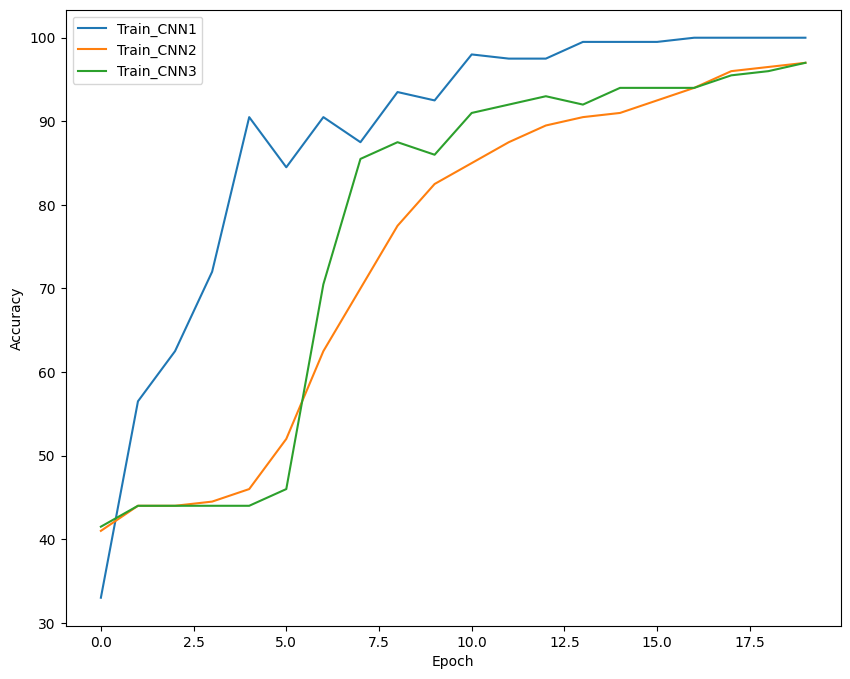

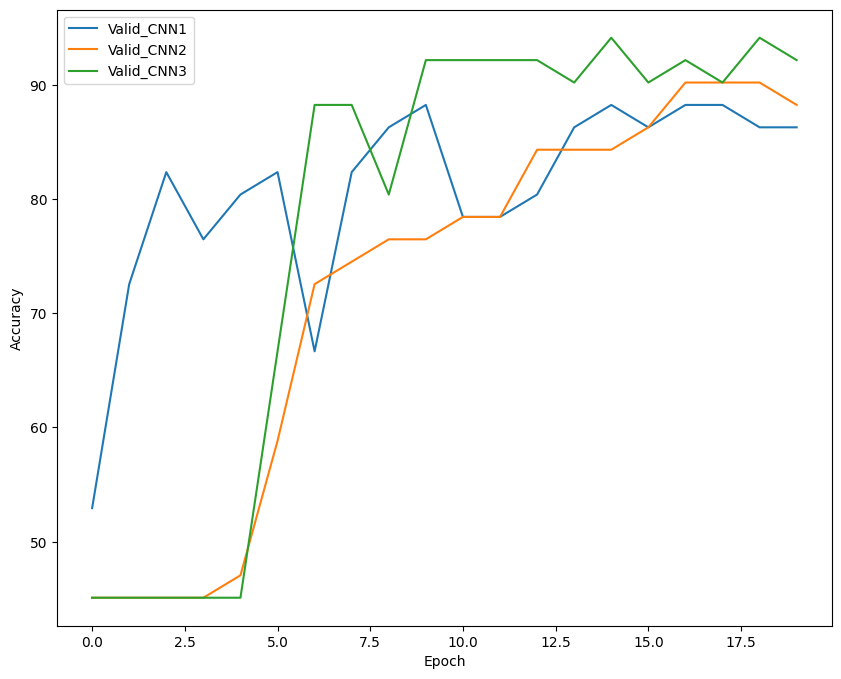

In [32]:
plot_metrics(train_model_dict,train_loss_dict,train_acc_dict,valid_loss_dict,valid_acc_dict)

Classification Report for CNN1
              precision    recall  f1-score   support

         0.0       0.84      0.91      0.87        23
         1.0       0.91      0.71      0.80        14
         2.0       0.87      0.93      0.90        14

    accuracy                           0.86        51
   macro avg       0.87      0.85      0.86        51
weighted avg       0.87      0.86      0.86        51





<Figure size 1000x800 with 0 Axes>

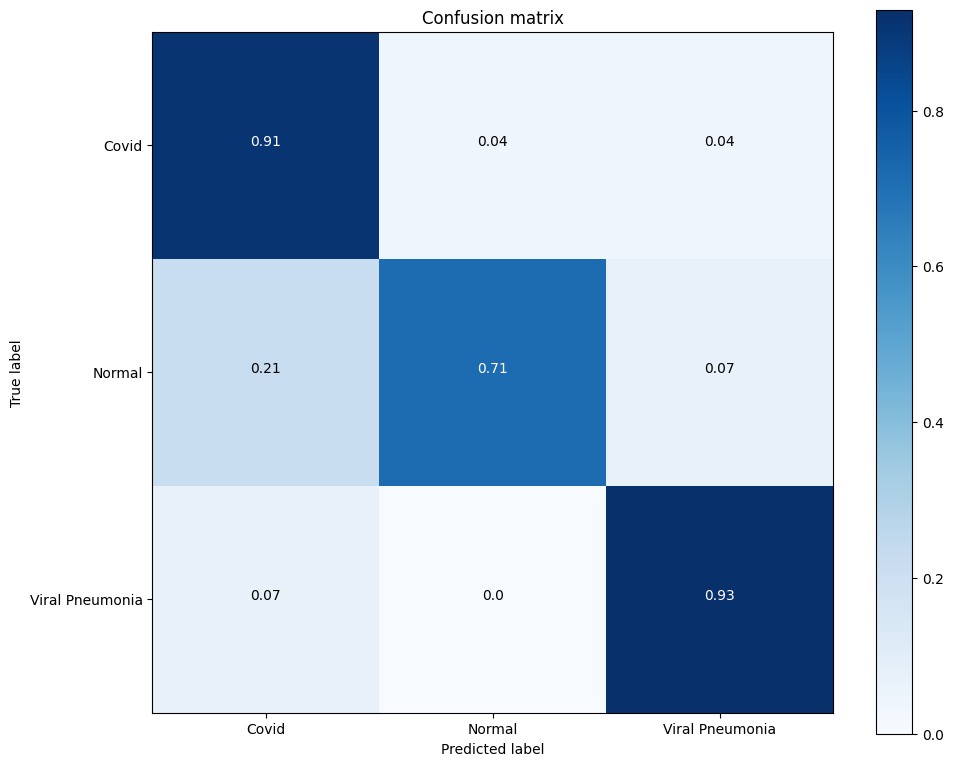

Classification Report for CNN2
              precision    recall  f1-score   support

         0.0       0.88      0.96      0.92        23
         1.0       0.92      0.79      0.85        14
         2.0       0.86      0.86      0.86        14

    accuracy                           0.88        51
   macro avg       0.88      0.87      0.87        51
weighted avg       0.88      0.88      0.88        51





<Figure size 1000x800 with 0 Axes>

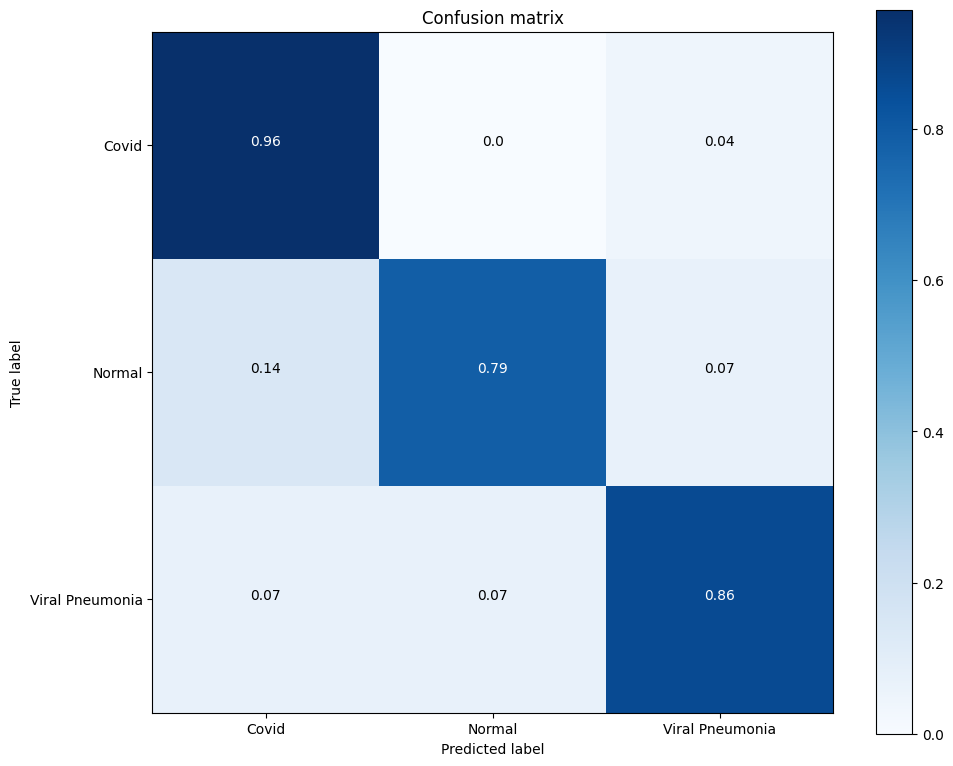

Classification Report for CNN3
              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95        23
         1.0       1.00      0.86      0.92        14
         2.0       0.78      1.00      0.88        14

    accuracy                           0.92        51
   macro avg       0.93      0.92      0.92        51
weighted avg       0.94      0.92      0.92        51





<Figure size 1000x800 with 0 Axes>

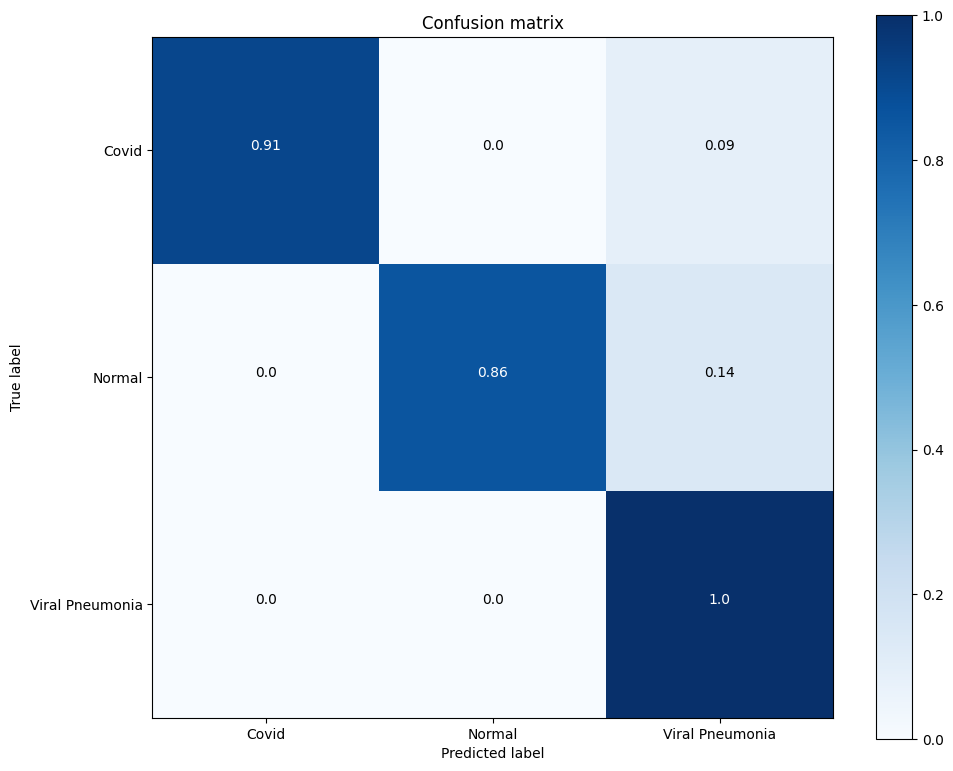

Accuracy  Precision    Recall  F1 score  Average cls Time
CNN1  0.862745   0.871919  0.851967  0.857184            0.0045
CNN2  0.882353   0.884603  0.866460  0.873321            0.0042
CNN3  0.921569   0.925926  0.923395  0.917541            0.0042

In [33]:
d=plot_report_confusion(train_model_dict,val)
d

我们评估了三种CNN架构：基础CNN（CNN1）、LeNet（CNN2）和AlexNet（CNN3）在性能上的差异。评估指标包括准确率、精确度、召回率、F1分数以及平均分类时间。结果显示，随着模型复杂度的增加，性能普遍提高。

CNN1作为最基础的CNN模型，在准确率上达到了86.27%，精确度为87.19%，召回率为85.20%，F1分数为85.72%，平均分类时间为0.0045秒。CNN2采用LeNet架构，相较于CNN1，其性能有所提

升，准确率提高到了88.24%，精确度为88.46%，召回率为86.65%，F1分数为87.33%，平均分类时间略微减少到0.0042秒。这表明LeNet架构通过其特定的网络层设计，能够更有效地捕捉图像特征，从而提高模型的整体性能。

CNN3采用的是更为复杂的AlexNet架构，其性能表现最为出色，准确率达到了92.16%，精确度为92.59%，召回率为92.34%，F1分数为91.75%，且其平均分类时间保持在0.0042秒。AlexNet的这种性能提升归因于其深层次的网络结构和更复杂的特征提取能力，能够更准确地处理和分类图像数据。

与之前分析的全连接神经网络（FNN）模型相比，高级CNN模型如AlexNet在准确率、精确度、召回率和F1分数上均显示出显著的优势，同时保持了相似的快速分类时间。这一结果凸显了在处理图像或需要高级特征提取的任务中，卷积神经网络的重要性和优越性。尤其是AlexNet，其在图像识别领域的应用中表现出了极高的准确性和效率。

综上所述，随着模型从基础的CNN到更复杂的AlexNet的过渡，我们可以观察到显著的性能提升，这突显了深度学习模型在处理复杂数据集时的强大能力。因此，在需要高准确率和细粒度识别的任务中，选择如AlexNet这样的高级CNN模型将是更优的选择。

# 最佳模型测试

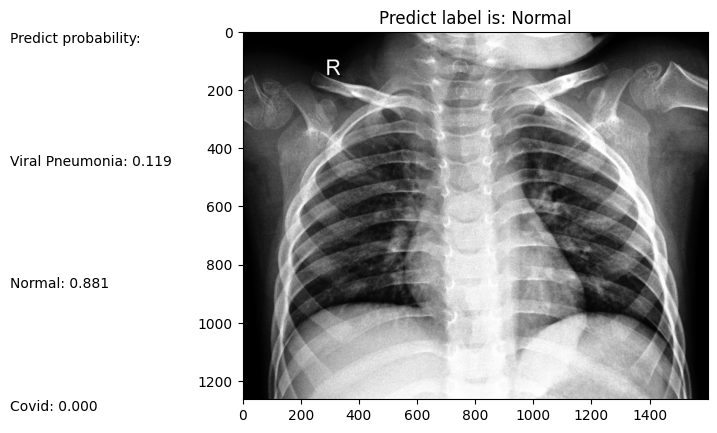

In [34]:
from PIL import Image
best_model=train_model_dict['CNN3']
best_model = best_model.to(device)


best_model.eval()
fig, ax = plt.subplots(figsize=(6, 6))
img = Image.open("/kaggle/input/covid19-image-dataset/Covid19-dataset/train/Normal/010.jpeg")
plt.imshow(img)
transform1 = transform.Compose([
    transform.Resize((224, 224)),
    transform.ToTensor(),
   transform.Normalize((0.485, 0.456, 0.406),(0.229,0.224,0.225)),
])
# Apply the transforms to the image
img = transform1(img)
img  =img .unsqueeze(0)

with torch.no_grad():
    output =best_model(img.to(device))

probs = torch.softmax(output, dim=1)[0]
prob_list = probs.tolist()
# Get the predicted class label
_, predicted = torch.max(output.data, 1)
class_labels={0:'Covid',1:'Normal',2:'Viral Pneumonia'}
labels = [class_labels[i] for i in range(len(class_labels))]
predicted_label = class_labels[predicted.item()]

img_pil = transform.ToPILImage()(img.squeeze())

plt.title('Predict label is: '+predicted_label)

# Add the label probabilities as text
for i, label in enumerate(labels):
    prob = prob_list[i]
    text = f"{label}: {prob:.3f}"
    plt.text(-0.5, (i)/3, text, transform=ax.transAxes, fontsize=10, verticalalignment='top')
plt.text(-0.5, 10/10, 'Predict probability: ', transform=ax.transAxes, fontsize=10, verticalalignment='top')
plt.show()
